In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error,
                             r2_score)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from sklearn.feature_selection import (SelectKBest, 
                                       f_regression)

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
warnings.filterwarnings('ignore')

## Data Set
- This data set contains details about individual residential property that was sold in Ames, Iowa from 2006 to 2010.     
- It contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous).  
- These observations/features can be used to assess the expected house prices.

Column descriptions can be found here: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt  
Data is available here: http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls  
Paper discussing dataset: https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true

In [2]:
home = os.path.expanduser('~')
data = pd.read_excel(f'../data/AmesHousing.xls')
data.drop('Order', axis='columns', inplace=True)
data.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Data cleaning and feature engineering

In [3]:
ordinal_features = {'Lot Shape': ['Reg','IR1', 'IR2', 'IR3'],
                    'Utilities':['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
                    'Land Slope':['Gtl', 'Mod', 'Sev'],
                    'Exter Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                    'Exter Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                    'Bsmt Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'],
                    'Bsmt Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'],
                    'Bsmt Exposure':['Gd', 'Av', 'Mn', 'No', 'NA'],
                    'BsmtFin Type 1':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
                    'BsmtFin Type 2':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
                    'Heating QC':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                    'Electrical':['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
                    'Kitchen Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                    'Functional':['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
                    'Fireplace Qu':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
                    'Garage Finish':['Fin', 'RFn', 'Unf', 'NA'],
                    'Garage Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'],
                    'Garage Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'],
                    'Paved Drive':['Y', 'P', 'N'],
                    'Pool QC':['Ex', 'Gd', 'TA', 'Fa','NA'],
                    'Fence':['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']}
                   

def transform_features(data, ordinal_features):
    # Convert ordinal catagroical features into numerical representation
    for feature, cats in ordinal_features.items():
        scores = reversed(range(1, len(cats)+1))
        mapping = dict(zip(cats, scores))
        data[feature] = data[feature].replace(mapping)
        data[feature] = pd.to_numeric(data[feature])
    
    # Drop any columns with over 25% na's
    data.dropna(thresh=len(data)*0.75, axis='columns', inplace=True)
    
    # Impute numerical columns with median and catagories with most frequent  
    numerical = data.select_dtypes('number').columns
    catagory = data.select_dtypes('object').columns
    imp_most_median = SimpleImputer(strategy='median')
    imp_most_frequent = SimpleImputer(strategy='most_frequent')
    data[numerical] = imp_most_median.fit_transform(data[numerical])
    data[catagory] = imp_most_frequent.fit_transform(data[catagory])

    # Create dummy columns for nominal catagorical data
    cat_features = data.select_dtypes('object').columns
    data = pd.get_dummies(data, columns=cat_features) 

    # Calculate years from date columns
    data["Year Built"] = 2019 - data["Year Built"] 
    data["Year Remod/Add"] = 2019 - data["Year Remod/Add"]
    data["Yr Sold"] = 2019 - data["Yr Sold"]
    data["Garage Yr Blt"] = 2019 - data["Garage Yr Blt"]
    
    # Make sure all columns are numeric and positive
    for col in data.columns:
        data[col] = pd.to_numeric(data[col])
        neg = data[data[col] < 0].index
        data.drop(neg, inplace=True)
        
    return data

data = transform_features(data, ordinal_features)
data.head()

,PID,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_N,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,526301100.0,20.0,141.0,31770.0,3.0,4.0,3.0,6.0,5.0,59.0,59.0,112.0,3.0,3.0,4.0,5.0,5.0,5.0,639.0,2.0,0.0,441.0,1080.0,2.0,5.0,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,3.0,7.0,8.0,2.0,59.0,4.0,2.0,528.0,4.0,4.0,2.0,210.0,62.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,215000.0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,

## Feature Selection
- Create train/test split
- Look at features manually

- Correlation to target
- Univatiate Selection
- Recursive Feature Elimination  m
- PCA 

https://machinelearningmastery.com/feature-selection-machine-learning-python/

#### Create train/test split

In [4]:
target = 'SalePrice'
features = [col for col in data.columns if col != target]
train, test = train_test_split(data, test_size=0.8, random_state=1)

#### Year of sale price
Does not seem to matter to any significant extent

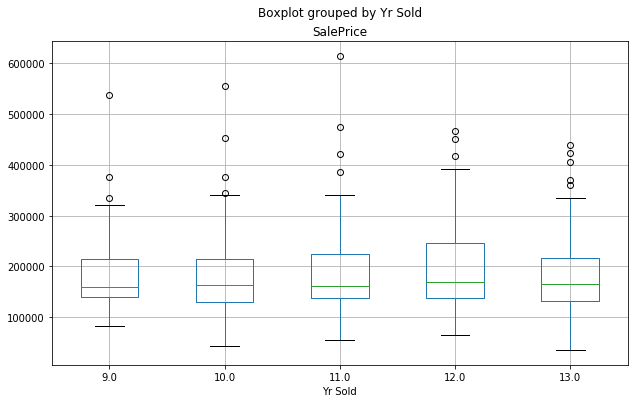

In [5]:
train.boxplot(column='SalePrice', by='Yr Sold', figsize=(10,6))

In [6]:
corr_features = train.corr()[target].abs().sort_values(ascending=False).head(11).drop(target)
corr_features

Overall Qual        0.801116
Kitchen Qual        0.675844
Gr Liv Area         0.668174
Exter Qual          0.643555
Garage Cars         0.631937
Garage Area         0.623172
Total Bsmt SF       0.613929
Bsmt Qual           0.610163
1st Flr SF          0.584182
Foundation_PConc    0.540591
Name: SalePrice, dtype: float64

#### F-regression univariate (higher scores are better)

In [7]:
kbest = SelectKBest(score_func= f_regression)
kbest.fit(train[features], train[[target]])
scores = pd.Series(dict(zip(features,kbest.scores_)))
uni_features = scores.sort_values(ascending=False)
uni_features.head(10)

Overall Qual        1044.523539
Kitchen Qual         490.199676
Gr Liv Area          470.213645
Exter Qual           412.157789
Garage Cars          387.605722
Garage Area          370.148819
Total Bsmt SF        352.657572
Bsmt Qual            345.785703
1st Flr SF           302.034061
Foundation_PConc     240.724368
dtype: float64

#### PCA

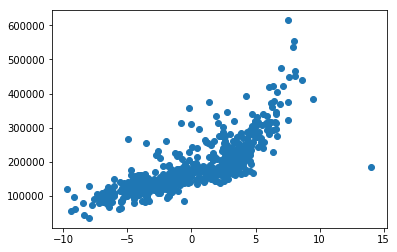

In [8]:
scaled_data = StandardScaler().fit_transform(train[features])
scaled_data = pd.DataFrame(scaled_data, columns=features)
pca = PCA(n_components=5)
pri_comp = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame(pri_comp)
plt.scatter(x=pca_data[0], y=train[target])

## Training and Testing

#### Using f-regression univariate and correlation features

In [52]:
lr = LinearRegression()
uni_features_cols = list(uni_features.index)
cv_scores = {}
for x in range(10, 100, 10):
    features = uni_features_cols[0:x]
    cv_score = cross_val_score(lr, train[features], train[[target]], cv=5)
    cv_scores[x] = [np.mean(cv_score),np.var(cv_score)]
cv_scores = pd.DataFrame(cv_scores, index=['average_score','varience']).transpose()
cv_scores.index.rename('num_best_features', inplace=True)
cv_scores.sort_values('average_score',ascending=False)

,average_score,varience
num_best_features,,
70,0.801733,0.016236
80,0.790895,0.009778
50,0.789811,0.018578
60,0.785785,0.019169
40,0.783167,0.017160
90,0.778716,0.010835
30,0.771404,0.021183
20,0.767043,0.023066
10,0.754268,0.019870


#### Bias vs Varience

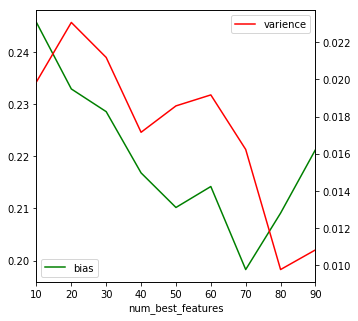

In [56]:
cv_scores['bias'] = 1 - cv_scores['average_score']
ax = cv_scores.plot(y='bias', style='g', figsize=(5, 5))
ax.legend(loc=3)
ax1 = ax.twinx()
cv_scores.plot(y='varience', ax=ax1, style='r-')

#### Using PCA features

In [13]:
lr = LinearRegression()
cv_scores = {}
for x in range(2, 20, 2):
    pca = PCA(n_components=x)
    pri_comp = pca.fit_transform(scaled_data)
    pca_data = pd.DataFrame(pri_comp)
    cv_score = cross_val_score(lr, pca_data, train[[target]], cv=5)
    cv_scores[x] = [np.mean(cv_score),np.var(cv_score)]
cv_scores = pd.DataFrame(cv_scores, index=['average_score','varience']).transpose()
cv_scores.index.rename('num_pca', inplace=True)
cv_scores.sort_values('average_score',ascending=False)

,average_score,varience
num_pca,,
6,0.760179,0.014383
10,0.758428,0.014518
8,0.757507,0.014431
12,0.752676,0.016384
14,0.748138,0.015953
16,0.743695,0.017139
18,0.740105,0.015031
4,0.732910,0.014324
2,0.626279,0.003833


## Predictions and error  
Using the top 70 f-regression univariate features gave the best result in testing

In [14]:
lr = LinearRegression()
best_features = uni_features_cols[0:90]
lr.fit(train[best_features], train[[target]])
predictions = lr.predict(test[features])
mse = mean_squared_error(test[[target]], predictions)
rmse = mse ** 0.5
r2 = r2_score(test[[target]], predictions)
print(f'RMSE: ${round(rmse)}')
print('R2 score:',round(r2,2))

RMSE: $33127.0
R2 score: 0.83
